# Benchmarking AUC using Pairwise Differences and Proximal Mappings
### (Demo Notebook File)
This notebook demonstrates the proximal optimization framework on controlled synthetic datasets using Support Vector Machine problems.

### Objectives
- Validate the ALM + SSN optimization algorithm
- Compare performance against baselines (BCE, LibAUC)
- Analyze sensitivity to hyperparameter σ (proximal penalty)
- Evaluate behavior across different problem geometries


### 1. Setup and Imports

In [1]:
import sys
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# notebooks/svm_example → repo root
ROOT = Path.cwd().parents[1]
PYTHON_SRC = ROOT / "src" / "python"

sys.path.insert(0, str(PYTHON_SRC))

print("Working on this file using Python source path:", PYTHON_SRC)


Working on this file using Python source path: /Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python


### 2. Generate Synthetic Data

We create two synthetic binary classification problems to test different aspects of the algorithm:

1. **Low-dimensional (2D)**: Easy to visualize, tests basic convergence
2. **High-dimensional (25D)**: Tests robustness in realistic feature spaces

#### Dataset Parameters

Each synthetic dataset is controlled by:
- **m**: Number of samples (fixed at 2000 for both)
- **n**: Number of features (2 vs 25 to test dimensionality effects)
- **sep_distance**: Distance between class centroids (controls problem difficulty)
  - Larger values → easier separation → higher baseline AUC
  - Smaller values → overlapping classes → more challenging
- **noise**: Standard deviation of Gaussian noise added to features
  - Tests robustness to noisy data
- **flip**: Label noise ratio (proportion of mislabeled samples)
  - Set to 0.0 for clean labels in this demo
- **class_ratios**: Balanced 50/50 split for fair comparison

#### Why These Configurations?

**Dataset 1** (m=2000, n=2, sep=2.0, noise=0.1):
- Low-dimensional for clear visualization of decision boundaries
- High separation (2.0) makes it "easier" - good for validating algorithm works
- Minimal noise to establish baseline behavior

**Dataset 2** (m=2000, n=25, sep=1.5, noise=0.2):
- Higher dimensional (25D) reflects realistic feature spaces
- Lower separation (1.5) + more noise (0.2) creates a harder problem
- Tests whether algorithm maintains performance as complexity increases
  
*Feel free to change parameters to test out different configurations!*

Dataset 1 — X shape: (2, 2000), Class counts: [1000 1000]


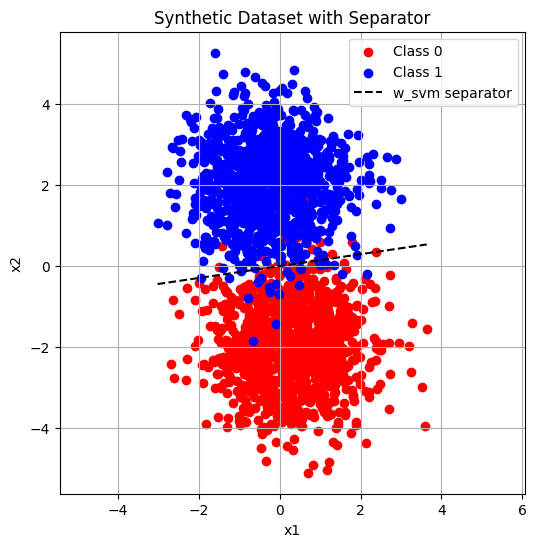

Dataset 2 — X shape: (25, 2000), Class counts: [1000 1000]


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


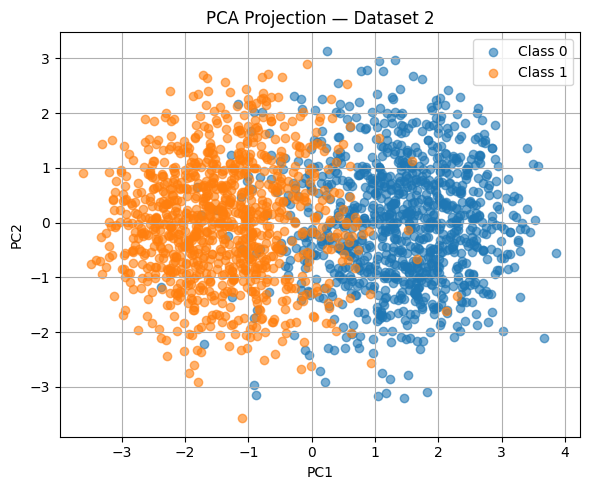

In [2]:
from aucopt.data.problem_svmdata import DataSet
from sklearn.preprocessing import StandardScaler
from aucopt.eval.graphs import plot_dataset_with_separator, plot_pca_projection

# Define two dataset configs only
dataset_configs = [
    {"m": 2000, "n": 2, "sep_distance": 2.0, "noise": 0.1, "flip": 0.0},  # Low-dim binary
    {"m": 2000, "n": 25, "sep_distance": 1.5, "noise": 0.2, "flip": 0.0},  # High-dim + noise
]

datasets = []

for i, cfg in enumerate(dataset_configs):
    
    ds = DataSet(
        m=cfg["m"],
        n=cfg["n"],
        num_classes=2,
        class_ratios=[0.5, 0.5],
        sep_distance=cfg["sep_distance"],
        feature_noise=cfg["noise"],
        flip_ratio=cfg["flip"],
        seed=1034 + i  # vary seed per dataset
    )
    
    datasets.append(ds)

    print(f"Dataset {i+1} — X shape: {ds.X.shape}, Class counts: {np.bincount(ds.y)}")

    # Visualize: 2D gets direct plot, high-dim gets PCA projection
    if ds.n == 2:
        plot_dataset_with_separator(ds)
    else:
        scaler = StandardScaler()
        ds_Xscaled = scaler.fit_transform(ds.X)
        plot_pca_projection(ds_Xscaled, ds.y, title=f"PCA Projection — Dataset {i+1}")

#### Visualization Notes

- **Dataset 1 (2D)**: Shows actual data distribution with decision boundary
- **Dataset 2 (25D)**: Shows PCA projection (2 principal components capture most variance)
  - PCA helps visualize high-dimensional structure but loses some information
  - Actual optimization happens in full 25D space

**Expected Output:**
- Dataset 1: ~1000 samples per class, clearly separable clusters
- Dataset 2: ~1000 samples per class, more overlap due to lower sep_distance + higher noise


### 3. Methodology Configuration

Set up optimization parameters and training configuration SGD-Prox Optimization Method in Pairwise Learning. 

In [3]:
from aucopt.optim.variables import ALMParameters, SSNParameters, LineSearchParameters

# ALM (Augmented Lagrangian Method) parameters
AP = ALMParameters(
    max_iter_alm=30,      # Maximum outer iterations
    tau_scale=0.9,        # Regularization update factor
    sigma_scale=10.0,     # Proximal penalty update factor
    tol_alm=1e-6          # Convergence tolerance
)

# SSN (Semi-Smooth Newton) subproblem parameters
SP = SSNParameters(
    tol_ssn=1e-6,         # Inner solver tolerance
    max_iter_ssn=50       # Max iterations per subproblem
)

# Line search parameters for step size selection
LS = LineSearchParameters(
    c=1e-4,               # Armijo condition constant
    max_iter_ls=15,       # Max line search iterations
    beta=0.95             # Backtracking factor
)

# Training configuration
TRAIN_CONFIG = {
    'n_epochs': 2,
    'n_batches': 5,
    'n_pos': 50,          # Positive pairs per batch
    'n_neg': 50,          # Negative pairs per batch
    'sigma0': 1.0,        # Initial proximal parameter
    'tau0': 1e-5,         # Initial regularization
    'alpha0': 1.0         # Initial step size
}

print("Configuration loaded. Ready to train models on datasets.")

Configuration loaded. Ready to train models on datasets.


### 4. Model Training 

Run Pairwise Prox-SGD optimization on each dataset and compare against baselines.

In [4]:
import os
import csv
import numpy as np
from aucopt.data.problem_instance import ProblemInstance
from aucopt.optim.sgd import run_prox_sgd_on_dataset
from aucopt.eval.baselines import evaluate_pytorch_bce, evaluate_libauc
from aucopt.eval.problem_summary import summarize_sample_efficiency

# Ensure results directory exists
os.makedirs("results", exist_ok=True)

# Store results for summary table
all_results = []

def safe_format(val):
    """Helper to safely format AUC values"""
    return f"{val:.4f}" if isinstance(val, float) else str(val)

### 4.1 Dataset 1 Implementation: Low Dimensional (2D)

#### Visualizing Initial State

Before training, we visualize how a **random weight vector** maps the pairwise differences into the proximal operator's domain.

**What to expect:**
- The x-axis shows `w^T(z_j - z_i) - λ_ij/σ` for each pair (i,j)
- The y-axis shows the proximal solution `y*_ij = prox_γ(w^T(z_j - z_i) - λ_ij/σ)`
- **Random initialization** means points are scattered across all regions of the piecewise linear surrogate `ℓ_δ(·)`

**Proximal mapping regions** (for σ = 1.0, i.e., γ = 1.0):
- **x < δ (correctly classified)**: Points where `w^T(z_j - z_i) < 0`, meaning the positive class scores lower than negative class (desired). Proximal map: `y* = x` (identity).
- **δ ≤ x ≤ δ + γ (transition region)**: Surrogate is linear, increasing. Proximal map: `y* = δ` (projection to threshold).
- **x > δ + γ (incorrectly classified)**: Points where `w^T(z_j - z_i) > 1`, meaning positive class scores much higher than negative class (wrong). Proximal map: `y* = x` (identity for γ=1.0).

With **random w**, most points will be **misclassified** (falling in the flat regions where the indicator function would be 1). The goal of optimization is to move these points into the correctly classified region (x < δ).

Train size: 1400, Test size: 600


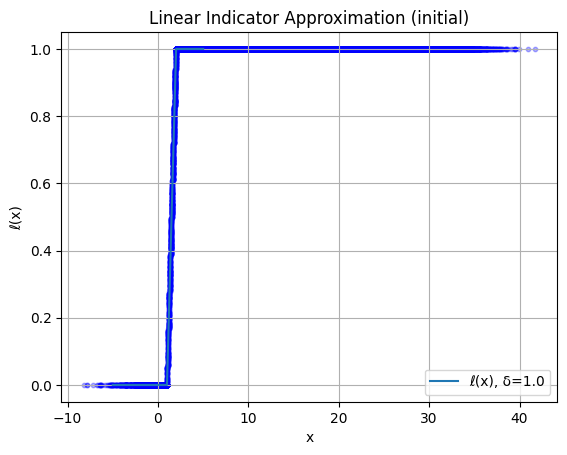

Saved initial state visualization.


In [5]:
i = 0
ds = datasets[i]
dataset_name = f"sgd_dataset_{i+1}"

# Create train/test split (70/30)
PI = ProblemInstance(ds.X, ds.y, mode='train_test', train_ratio=0.7)
print(f"Train size: {PI.X.shape[1]}, Test size: {PI.X_test.shape[1]}")

from aucopt.eval.graphs import plot_linear_indicator, scatter_prox_points
import matplotlib.pyplot as plt

# Random initialization
random_w = np.random.randn(PI.X.shape[0])

# Plot initial proximal mapping
f = plot_linear_indicator(delta=1.0, label="initial")
scatter_prox_points(
    random_w, 
    lambda_vec=np.zeros(len(PI.K)), 
    sigma=1.0, 
    PI=PI, 
    f=f, 
    label="initial"
)
plt.savefig(f"results/{dataset_name}_prox_init.png")
plt.show()
print(f"Saved initial state visualization.")

#### Run Prox-SGD Optimization

Train the model using controlled pairwise sampling:
- **2 epochs** with **5 batches** per epoch
- Sample **50 positive + 50 negative pairs** per batch
- Total pairwise comparisons per epoch: 5 × (50 × 50) = 12,500 pairs

In [6]:
from types import SimpleNamespace

ds_train = SimpleNamespace(X=PI.X, y=PI.y)

print(f"\n{'='*60}")
print(f"Running Prox-SGD on {dataset_name}")
print(f"{'='*60}\n")

w = run_prox_sgd_on_dataset(
    ds=ds_train,
    AP=AP,
    SP=SP,
    LS=LS,
    dataset_name=dataset_name,
    n_epochs=TRAIN_CONFIG['n_epochs'],
    n_batches=TRAIN_CONFIG['n_batches'],
    n_pos=TRAIN_CONFIG['n_pos'],
    n_neg=TRAIN_CONFIG['n_neg'],
    sigma0=TRAIN_CONFIG['sigma0'],
    tau0=TRAIN_CONFIG['tau0'],
    alpha0=TRAIN_CONFIG['alpha0'],
    save_weights=True,
    plot_weights=False,
    output_dir="results"
)

print(f"Training complete.")


Running Prox-SGD on sgd_dataset_1

Epoch 1


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: divide by zero encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: overflow encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: invalid value encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: divide by zero encountered in matmul
  proxvar.d_D = PI.D.T @ d
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: overflow encountered in matmul
  proxvar.d_D = PI.D.T @ d
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: inv

Epoch 2
✅ Saved final weights to results/sgd_dataset_1_w_sgd.csv
Training complete.


#### Visualizing Final State

After training, observe how the optimization **moved pairwise differences** through the proximal mapping regions.

**What we should see:**
- **Convergence to correct region**: Most points should now fall in the region where `w^T(z_j - z_i) < δ` (x < 0 for δ=0)
  - This means positive class consistently scores **lower** than negative class in the learned embedding
  - Proximal operator maps these to `y* = x` (identity in the flat region)
  
- **Why γ = 1.0 (σ = 1.0) works well**:
  - For γ < 2, the proximal mapping has **sharp transitions** between regions
  - Points that reach the correct classification region (`x < δ`) **stay there** because `∇y* = I` (identity gradient)
  - The transition region `[δ, δ+γ]` is narrow enough to avoid getting "stuck" but wide enough for stable updates

- **Comparison to initial state**:
  - Initially: Points scattered, many in wrong regions
  - Finally: Points concentrated in correct region (x < δ), indicating successful optimization

**Note**: For γ ≥ 2 (σ ≤ 0.5), the subdifferential region `[0, I]` at x = δ + √(2γ) can cause points to cluster near the non-differentiable boundary rather than fully entering the correct classification region. This is why **σ = 1.0 (γ = 1.0) provides better convergence** as shown in the experimental results.

See **Section 2.2.1** of the technical notes for complete proximal mapping derivations and **Table 1-2** for empirical validation showing σ = 1.0 achieves best AUC across problem geometries.

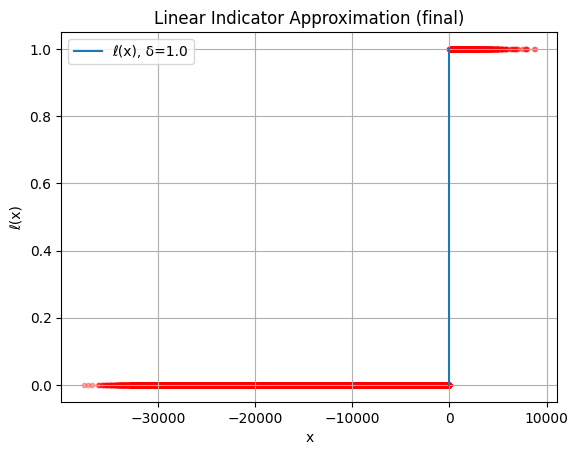

Saved final state visualization.


In [7]:
# Plot final proximal mapping
f = plot_linear_indicator(delta=1.0, label="final")
scatter_prox_points(
    w, 
    lambda_vec=np.zeros(len(PI.K)), 
    sigma=1.0, 
    PI=PI, 
    f=f, 
    label="final"
)
plt.savefig(f"results/{dataset_name}_prox_final.png")
plt.show()
print(f"Saved final state visualization.")

#### Evaluate Performance

Compare against standard methods:
- **PyTorch BCE**: Binary cross-entropy with standard SGD
- **LibAUC PESG**: State-of-the-art AUC optimization library

In [8]:
from aucopt.eval.graphs import evaluate_auc_on_test

# Prox-SGD AUC on test set
auc_sgd = evaluate_auc_on_test(w, PI, dataset_name=dataset_name)
print(f"Prox-SGD Test AUC: {safe_format(auc_sgd)}")

# Sample efficiency analysis
summarize_sample_efficiency(
    PI, 
    TRAIN_CONFIG['n_epochs'],
    TRAIN_CONFIG['n_batches'],
    TRAIN_CONFIG['n_pos'],
    TRAIN_CONFIG['n_neg'],
    dataset_name=dataset_name
)

Saved ROC plot to results/sgd_dataset_1_roc.png
Saved AUC value to results/sgd_dataset_1_auc.csv
Test AUC for sgd_dataset_1: 0.9940
Prox-SGD Test AUC: 0.9940

--- Sample Efficiency Summary ---
Dataset: sgd_dataset_1
Total training samples available: 1400
Total samples used (SGD batches): 100 × 5 × 2 = 1000


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: divide by zero encountered in matmul
  scores = w @ PI.X_test
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: overflow encountered in matmul
  scores = w @ PI.X_test
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: invalid value encountered in matmul
  scores = w @ PI.X_test


In [9]:
# Prepare data (transpose for PyTorch/LibAUC conventions)
X_train = PI.X.T
y_train = PI.y
X_test = PI.X_test.T
y_test = PI.y_test

# Evaluate baselines
print("\nRunning baseline methods...")
auc_pytorch, _ = evaluate_pytorch_bce(X_train, X_test, y_train, y_test)
auc_libauc, _ = evaluate_libauc(X_train, X_test, y_train, y_test)

print(f"PyTorch BCE AUC:  {safe_format(auc_pytorch)}")
print(f"LibAUC PESG AUC:  {safe_format(auc_libauc)}")


Running baseline methods...
PyTorch BCE AUC:  0.9951
LibAUC PESG AUC:  0.9877



Running PyTorch BCE...
Running LibAUC PESG...


/var/folders/lj/r44wsqnj64d42xclq3w52d2w0000gn/T/ipykernel_43465/1447507999.py:11: RuntimeWarning: divide by zero encountered in matmul
  scores_prox = w @ PI.X_test
/var/folders/lj/r44wsqnj64d42xclq3w52d2w0000gn/T/ipykernel_43465/1447507999.py:11: RuntimeWarning: overflow encountered in matmul
  scores_prox = w @ PI.X_test
/var/folders/lj/r44wsqnj64d42xclq3w52d2w0000gn/T/ipykernel_43465/1447507999.py:11: RuntimeWarning: invalid value encountered in matmul
  scores_prox = w @ PI.X_test


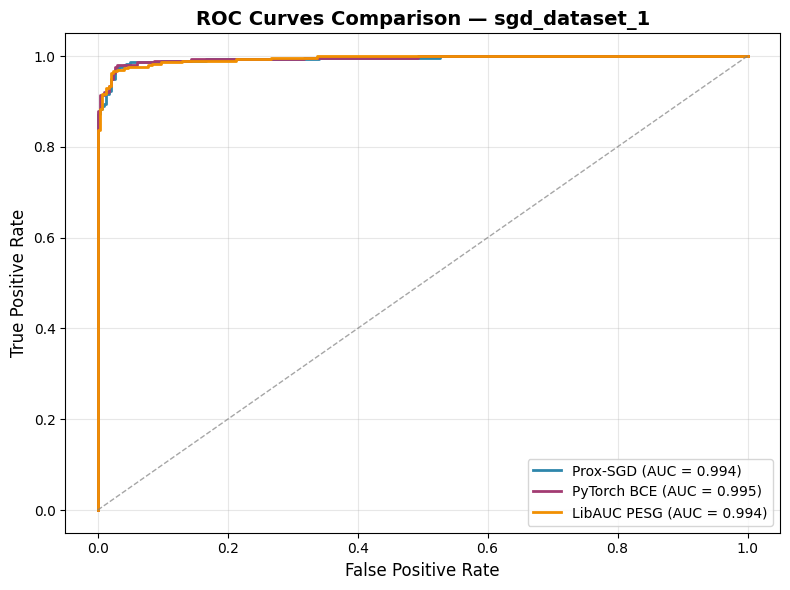


AUC Summary for sgd_dataset_1
Prox-SGD:     0.9940
PyTorch BCE:  0.9946
LibAUC PESG:  0.9943



In [10]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Prepare data (transpose for PyTorch/LibAUC conventions)
X_train = PI.X.T
y_train = PI.y
X_test = PI.X_test.T
y_test = PI.y_test

# 1. Prox-SGD scores (already have w from training)
scores_prox = w @ PI.X_test
auc_prox = roc_auc_score(y_test, scores_prox)
fpr_prox, tpr_prox, _ = roc_curve(y_test, scores_prox)

# 2. PyTorch BCE baseline
print("\nRunning PyTorch BCE...")
auc_pytorch, scores_pytorch = evaluate_pytorch_bce(X_train, X_test, y_train, y_test)
fpr_pytorch, tpr_pytorch, _ = roc_curve(y_test, scores_pytorch)

# 3. LibAUC baseline
print("Running LibAUC PESG...")
auc_libauc, scores_libauc = evaluate_libauc(X_train, X_test, y_train, y_test)
fpr_libauc, tpr_libauc, _ = roc_curve(y_test, scores_libauc)

# Plot all three ROC curves
plt.figure(figsize=(8, 6))

plt.plot(fpr_prox, tpr_prox, linewidth=2, 
         label=f"Prox-SGD (AUC = {auc_prox:.3f})", color='#2E86AB')
plt.plot(fpr_pytorch, tpr_pytorch, linewidth=2, 
         label=f"PyTorch BCE (AUC = {auc_pytorch:.3f})", color='#A23B72')
plt.plot(fpr_libauc, tpr_libauc, linewidth=2, 
         label=f"LibAUC PESG (AUC = {auc_libauc:.3f})", color='#F18F01')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1, alpha=0.7)

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"ROC Curves Comparison — {dataset_name}", fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(f"results/{dataset_name}_roc_comparison.png", dpi=150)
plt.show()

print(f"\n{'='*50}")
print(f"AUC Summary for {dataset_name}")
print(f"{'='*50}")
print(f"Prox-SGD:     {auc_prox:.4f}")
print(f"PyTorch BCE:  {auc_pytorch:.4f}")
print(f"LibAUC PESG:  {auc_libauc:.4f}")
print(f"{'='*50}\n")

# Store for summary
all_results.append({
    'dataset': dataset_name,
    'prox_sgd': auc_prox,
    'pytorch_bce': auc_pytorch,
    'libauc_pesg': auc_libauc
})

#### Save Results

In [11]:
# Save comparison to CSV
csv_path = f"results/auc_comparison_{dataset_name}.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Method", "AUC"])
    writer.writerow(["Prox-SGD", safe_format(auc_sgd)])
    writer.writerow(["PyTorch BCE", safe_format(auc_pytorch)])
    writer.writerow(["LibAUC PESG", safe_format(auc_libauc)])

print(f" Saved results to {csv_path}")

# Store for summary
all_results.append({
    'dataset': dataset_name,
    'prox_sgd': auc_sgd,
    'pytorch_bce': auc_pytorch,
    'libauc_pesg': auc_libauc
})

 Saved results to results/auc_comparison_sgd_dataset_1.csv


### 4.2 Dataset 2: High-Dimensional (25D)

#### Visualizing Initial State

Train size: 1400, Test size: 600


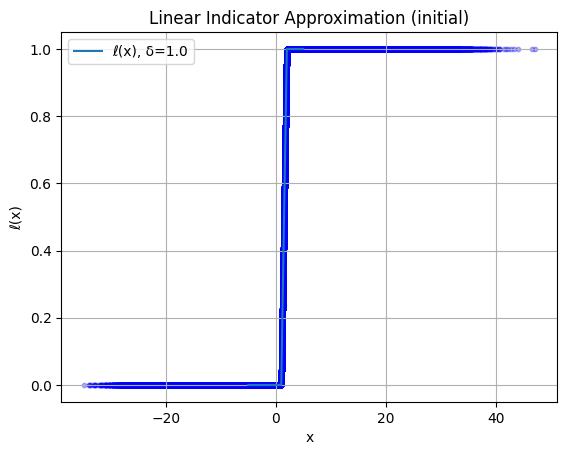

 Saved initial state visualization.


In [12]:
i = 1
ds = datasets[i]
dataset_name = f"sgd_dataset_{i+1}"

# Create train/test split (70/30)
PI = ProblemInstance(ds.X, ds.y, mode='train_test', train_ratio=0.7)
print(f"Train size: {PI.X.shape[1]}, Test size: {PI.X_test.shape[1]}")

from aucopt.eval.graphs import plot_linear_indicator, scatter_prox_points
import matplotlib.pyplot as plt

# Random initialization
random_w = np.random.randn(PI.X.shape[0])

# Plot initial proximal mapping
f = plot_linear_indicator(delta=1.0, label="initial")
scatter_prox_points(
    random_w, 
    lambda_vec=np.zeros(len(PI.K)), 
    sigma=1.0, 
    PI=PI, 
    f=f, 
    label="initial"
)
plt.savefig(f"results/{dataset_name}_prox_init.png")
plt.show()
print(f" Saved initial state visualization.")

#### Run Prox-SGD Optimization

Train the model using controlled pairwise sampling:
- **2 epochs** with **5 batches** per epoch
- Sample **50 positive + 50 negative pairs** per batch
- Total pairwise comparisons per epoch: 5 × (50 × 50) = 12,500 pairs

In [13]:
from types import SimpleNamespace

print(f"\n{'='*60}")
print(f"Running Prox-SGD on {dataset_name}")
print(f"{'='*60}\n")

ds_train = SimpleNamespace(X=PI.X, y=PI.y)

w = run_prox_sgd_on_dataset(
    ds=ds_train,
    AP=AP,
    SP=SP,
    LS=LS,
    dataset_name=dataset_name,
    n_epochs=TRAIN_CONFIG['n_epochs'],
    n_batches=TRAIN_CONFIG['n_batches'],
    n_pos=TRAIN_CONFIG['n_pos'],
    n_neg=TRAIN_CONFIG['n_neg'],
    sigma0=TRAIN_CONFIG['sigma0'],
    tau0=TRAIN_CONFIG['tau0'],
    alpha0=TRAIN_CONFIG['alpha0'],
    save_weights=True,
    plot_weights=False,
    output_dir="results"
)

print(f"Training complete.")


Running Prox-SGD on sgd_dataset_2

Epoch 1


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: divide by zero encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: overflow encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: invalid value encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: divide by zero encountered in matmul
  proxvar.d_D = PI.D.T @ d
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: overflow encountered in matmul
  proxvar.d_D = PI.D.T @ d
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: inv

Epoch 2
✅ Saved final weights to results/sgd_dataset_2_w_sgd.csv
Training complete.


#### Visualizing Final State

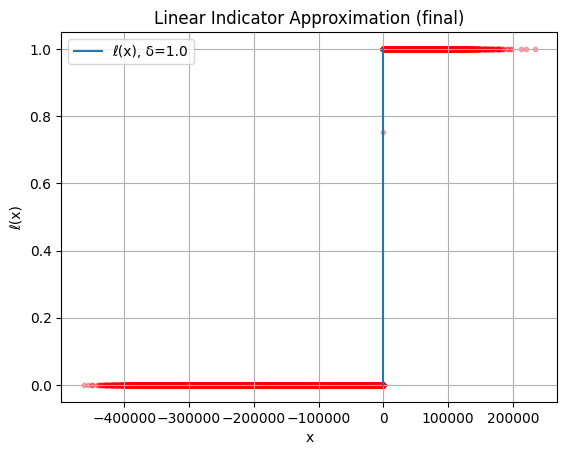

 Saved final state visualization


In [14]:
# Plot final proximal mapping
f = plot_linear_indicator(delta=1.0, label="final")
scatter_prox_points(
    w, 
    lambda_vec=np.zeros(len(PI.K)), 
    sigma=1.0, 
    PI=PI, 
    f=f, 
    label="final"
)
plt.savefig(f"results/{dataset_name}_prox_final.png")
plt.show()
print(f" Saved final state visualization")

#### Evaluate Performance

In [15]:
from aucopt.eval.graphs import evaluate_auc_on_test

# Prox-SGD AUC on test set
auc_sgd = evaluate_auc_on_test(w, PI, dataset_name=dataset_name)
print(f"Prox-SGD Test AUC: {safe_format(auc_sgd)}")

# Sample efficiency analysis
summarize_sample_efficiency(
    PI, 
    TRAIN_CONFIG['n_epochs'],
    TRAIN_CONFIG['n_batches'],
    TRAIN_CONFIG['n_pos'],
    TRAIN_CONFIG['n_neg'],
    dataset_name=dataset_name
)

Saved ROC plot to results/sgd_dataset_2_roc.png
Saved AUC value to results/sgd_dataset_2_auc.csv
Test AUC for sgd_dataset_2: 0.9653
Prox-SGD Test AUC: 0.9653

--- Sample Efficiency Summary ---
Dataset: sgd_dataset_2
Total training samples available: 1400
Total samples used (SGD batches): 100 × 5 × 2 = 1000


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: divide by zero encountered in matmul
  scores = w @ PI.X_test
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: overflow encountered in matmul
  scores = w @ PI.X_test
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: invalid value encountered in matmul
  scores = w @ PI.X_test


In [16]:
# Prepare data (transpose for PyTorch/LibAUC conventions)
X_train = PI.X.T
y_train = PI.y
X_test = PI.X_test.T
y_test = PI.y_test

# Evaluate baselines
print("\nRunning baseline methods...")
auc_pytorch, _ = evaluate_pytorch_bce(X_train, X_test, y_train, y_test)
auc_libauc, _ = evaluate_libauc(X_train, X_test, y_train, y_test)

print(f"PyTorch BCE AUC:  {safe_format(auc_pytorch)}")
print(f"LibAUC PESG AUC:  {safe_format(auc_libauc)}")


Running baseline methods...
PyTorch BCE AUC:  0.9799
LibAUC PESG AUC:  0.9722



Running PyTorch BCE...
Running LibAUC PESG...


/var/folders/lj/r44wsqnj64d42xclq3w52d2w0000gn/T/ipykernel_43465/1447507999.py:11: RuntimeWarning: divide by zero encountered in matmul
  scores_prox = w @ PI.X_test
/var/folders/lj/r44wsqnj64d42xclq3w52d2w0000gn/T/ipykernel_43465/1447507999.py:11: RuntimeWarning: overflow encountered in matmul
  scores_prox = w @ PI.X_test
/var/folders/lj/r44wsqnj64d42xclq3w52d2w0000gn/T/ipykernel_43465/1447507999.py:11: RuntimeWarning: invalid value encountered in matmul
  scores_prox = w @ PI.X_test


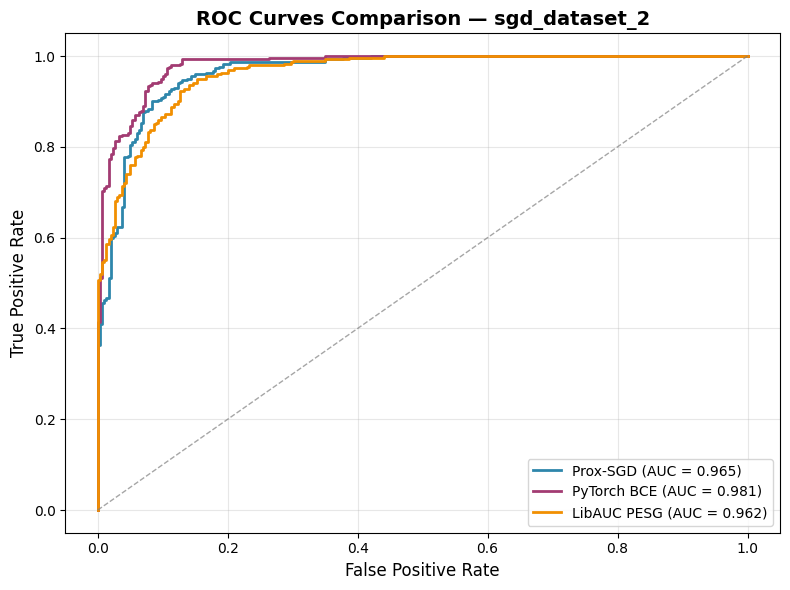


AUC Summary for sgd_dataset_2
Prox-SGD:     0.9653
PyTorch BCE:  0.9806
LibAUC PESG:  0.9623



In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Prepare data (transpose for PyTorch/LibAUC conventions)
X_train = PI.X.T
y_train = PI.y
X_test = PI.X_test.T
y_test = PI.y_test

# 1. Prox-SGD scores (already have w from training)
scores_prox = w @ PI.X_test
auc_prox = roc_auc_score(y_test, scores_prox)
fpr_prox, tpr_prox, _ = roc_curve(y_test, scores_prox)

# 2. PyTorch BCE baseline
print("\nRunning PyTorch BCE...")
auc_pytorch, scores_pytorch = evaluate_pytorch_bce(X_train, X_test, y_train, y_test)
fpr_pytorch, tpr_pytorch, _ = roc_curve(y_test, scores_pytorch)

# 3. LibAUC baseline
print("Running LibAUC PESG...")
auc_libauc, scores_libauc = evaluate_libauc(X_train, X_test, y_train, y_test)
fpr_libauc, tpr_libauc, _ = roc_curve(y_test, scores_libauc)

# Plot all three ROC curves
plt.figure(figsize=(8, 6))

plt.plot(fpr_prox, tpr_prox, linewidth=2, 
         label=f"Prox-SGD (AUC = {auc_prox:.3f})", color='#2E86AB')
plt.plot(fpr_pytorch, tpr_pytorch, linewidth=2, 
         label=f"PyTorch BCE (AUC = {auc_pytorch:.3f})", color='#A23B72')
plt.plot(fpr_libauc, tpr_libauc, linewidth=2, 
         label=f"LibAUC PESG (AUC = {auc_libauc:.3f})", color='#F18F01')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1, alpha=0.7)

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"ROC Curves Comparison — {dataset_name}", fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(f"results/{dataset_name}_roc_comparison.png", dpi=150)
plt.show()

print(f"\n{'='*50}")
print(f"AUC Summary for {dataset_name}")
print(f"{'='*50}")
print(f"Prox-SGD:     {auc_prox:.4f}")
print(f"PyTorch BCE:  {auc_pytorch:.4f}")
print(f"LibAUC PESG:  {auc_libauc:.4f}")
print(f"{'='*50}\n")

# Store for summary
all_results.append({
    'dataset': dataset_name,
    'prox_sgd': auc_prox,
    'pytorch_bce': auc_pytorch,
    'libauc_pesg': auc_libauc
})

#### Save Results

In [18]:
# Save comparison to CSV
csv_path = f"results/auc_comparison_{dataset_name}.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Method", "AUC"])
    writer.writerow(["Prox-SGD", safe_format(auc_sgd)])
    writer.writerow(["PyTorch BCE", safe_format(auc_pytorch)])
    writer.writerow(["LibAUC PESG", safe_format(auc_libauc)])

print(f" Saved results to {csv_path}")

# Store for summary
all_results.append({
    'dataset': dataset_name,
    'prox_sgd': auc_sgd,
    'pytorch_bce': auc_pytorch,
    'libauc_pesg': auc_libauc
})

 Saved results to results/auc_comparison_sgd_dataset_2.csv
